# **Imports**

In [ ]:
!pip install transformers

In [ ]:
import json
import torch
import os
import re
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/sup_model'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['=4.5.0', 'ArgEvi_dataset.py', 'Roberta.py', '__pycache__', 'cl_train.py', 'claim_arg_support.py', 'contrastive_loss.py', 'data_prep.py', 'fever_sufficient_facts.jsonl', 'model.pt', 'model_1.pt', 'models', 'perspective_pool_v1.0.json', 'perspectrum_with_answers_v1.0.json', 'pos_neg_pairs_train.csv', 'requirements.txt', 'runs', 'sup_Roberta_CL.ipynb', 'sup_Roberta_CL_1.ipynb', 'sup_claim_arg.ipynb', 'support_model_test.ipynb', 'tokenized_data.py', 'vitaminc_500.py', 'vitaminc_dataset.xlsx']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## **Dataset**

In [ ]:
from ArgEvi_dataset import ArgEvi


file_path = 'pos_neg_pairs_train.csv'

# [argument, positive evidence, 5 negative evidences]
dataset = ArgEvi(file_path)

# split tripletdataset into training, val and test dataset
size = len(dataset)
train_size = int(size * 0.8)
val_size = int(size * 0.2)
print(size)

train_dataset = dataset[:train_size]
val_dataset = dataset[train_size:(train_size + val_size)]

train_arguments = []
train_pos_evi = []
train_neg_evis = []

for sample in train_dataset:
  train_arguments.append(sample[0])
  train_pos_evi.append(sample[1])
  train_neg_evis.append(sample[2:])     # list of 5 negative evidences

print((train_arguments[0], train_pos_evi[0], train_neg_evis[0]))

val_arguments = []
val_pos_evi = []
val_neg_evis = []

for sample in val_dataset:
  val_arguments.append(sample[0])
  val_pos_evi.append(sample[1])
  val_neg_evis.append(sample[2:])


['We should end affirmative action', 'Williams believes programs such as affirmative action and minimum wage laws set up to aide minorities have, in fact, been harmful to them and stifled their ability to advance in society.', 'In the 2000 campaign, Lieberman assured the black voters, "I have supported affirmative action, I do support affirmative action, and I will support affirmative action because history and current reality make it necessary."[REF] .', 'In 1970, the federal Office for Civil Rights issued a memorandum which stated that school districts must take affirmative action to ensure that the native language of minority students did not inhibit their participation in the educational system.', "Researchers found that a removal of affirmative action policies from all colleges and universities would result in a significant drop in minority presence in all institutions of higher education, upholding affirmative action's role in diversity in the American classroom.", 'As President 

In [ ]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_arg_tokens = tokenizer(train_arguments, truncation=True, padding='max_length', max_length=512, return_tensors="pt")
train_pos_tokens = tokenizer(train_pos_evi, return_tensors='pt', padding=True, truncation=True, max_length=512)
#train_neg_tokens = [tokenizer(negs, return_tensors='pt', padding=True, truncation=True, max_length=512) for negs in train_neg_evis]
input_ids = torch.stack([
    torch.stack([tokenizer(neg, return_tensors='pt', padding='max_length', truncation=True, max_length=512)['input_ids'].squeeze(0) for neg in negs])
    for negs in train_neg_evis
])

attention_masks = torch.stack([
    torch.stack([tokenizer(neg, return_tensors='pt', padding='max_length', truncation=True, max_length=512)['attention_mask'].squeeze(0) for neg in negs])
    for negs in train_neg_evis
])

train_neg_tokens = {
    'input_ids': input_ids,
    'attention_mask': attention_masks
}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
'''
print(train_neg_tokens)
print("Shape of 'input_ids':", train_neg_tokens['input_ids'].shape)
print("Shape of 'attention_mask':", train_neg_tokens['attention_mask'].shape)
'''

'\nprint(train_neg_tokens)\nprint("Shape of \'input_ids\':", train_neg_tokens[\'input_ids\'].shape)\nprint("Shape of \'attention_mask\':", train_neg_tokens[\'attention_mask\'].shape)\n'

In [ ]:
val_arg_tokens = tokenizer(val_arguments, truncation=True, padding='max_length', max_length=512, return_tensors="pt")
#print(train_pos_evi[0])
print(val_pos_evi)
val_pos_tokens = tokenizer(val_pos_evi, return_tensors='pt', padding=True, truncation=True, max_length=512)

val_input_ids = torch.stack([
    torch.stack([tokenizer(neg, return_tensors='pt', padding='max_length', truncation=True, max_length=512)['input_ids'].squeeze(0) for neg in negs])
    for negs in val_neg_evis
])

val_attention_masks = torch.stack([
    torch.stack([tokenizer(neg, return_tensors='pt', padding='max_length', truncation=True, max_length=512)['attention_mask'].squeeze(0) for neg in negs])
    for negs in val_neg_evis
])

val_neg_tokens = {
    'input_ids': val_input_ids,
    'attention_mask': val_attention_masks
}

['Romney has declared his support for abstinence-only sex education in public schools.', 'Siyafundisa ("Teaching Our Children"), a five-year project to reduce HIV/AIDS incidence in South Africa, Mozambique, and Namibia by promoting abstinence until marriage, being faithful, and avoidance of unhealthy behaviors affecting youth.', 'Dr. Cheever is an outspoken critic of the consumption of foie gras, has contributed to numerous publications advocating vegetarianism,[REF] and is a prominent proponent of other animal rights causes including banning organized equestrian sports.', 'Hansen said that mountaintop removal for coal mining "[provides] only a small fraction of our energy" and "should be abolished."[REF]', 'Dr. Anthony Ingraffea, D. C. Baum Professor of Engineering at Cornell University, whose research has involved fracture mechanics for more than 30 years, has said that drilling and hydraulic fracturing can liberate biogenic natural gas into a fresh water aquifer.', 'By 1998, Beaumon

# **Dataloader**

In [ ]:
# arg_tokens, pos_tokens, neg_tokens = data
from tokenized_data import TokenizedDataset

train_tokenized_dataset = TokenizedDataset(train_arg_tokens, train_pos_tokens, train_neg_tokens)
val_tokenized_dataset = TokenizedDataset(val_arg_tokens, val_pos_tokens, val_neg_tokens)

batch_size = 16

train_dataloader = DataLoader(train_tokenized_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_tokenized_dataset, batch_size=batch_size, shuffle=True)



In [ ]:
print(train_tokenized_dataset.__getitem__(0)[0]['input_ids'].shape)

torch.Size([512])


In [ ]:
print(train_tokenized_dataset.__getitem__(0)[2]['input_ids'].shape)

torch.Size([5, 512])


# **Training**

In [ ]:
from Roberta import ContrastiveRoberta
# from cl_train import train
from torch import nn
import torch.optim as optim
from contrastive_loss import ContrastiveLoss
import torch.nn.functional as F


# Goal: learn embeddings such that those from supportive argument-evidence pairs are closer together
#.      than those from non-supportive pairs.
def evaluate(arg_emb, pos_emb, neg_embs):
    pos_sim = F.cosine_similarity(arg_emb.unsqueeze(1), pos_emb.unsqueeze(0), dim=-1)
    avg_pos_sim = torch.mean(pos_sim).item()

    batch_size, num_negatives, emb_dim = neg_embs.shape
    neg_embs_flat = neg_embs.view(batch_size * num_negatives, emb_dim)
    neg_sim = F.cosine_similarity(arg_emb.unsqueeze(1), neg_embs_flat.unsqueeze(0), dim=-1)
    avg_neg_sim = torch.mean(neg_sim).item()

    return avg_pos_sim, avg_neg_sim


def train(model: nn.Module,
          train_dataloader: DataLoader,
          val_dataloader: DataLoader,
          optimizer: optim.Optimizer,
          contrastive_loss,
          num_epochs: int,
          device: torch.device
          ):

    train_contrastive_loss = []
    val_contrastive_loss = []

    # early stopping initial
    patience = 2
    best_val_loss = float('inf')
    count = 0   # number of epoches with no reduction of val_loss


    for epoch in range(num_epochs):
        model.to(device)

        model.train()
        running_loss = 0.0
        epoch_loss = 0.0

        for i, data in enumerate(train_dataloader, 0):
            arg_tokens, pos_tokens, neg_tokens = data

            arg_tokens = {key: val.to(device) for key, val in arg_tokens.items()}
            pos_tokens = {key: val.to(device) for key, val in pos_tokens.items()}
            neg_tokens = {key: val.to(device) for key, val in neg_tokens.items()}


            optimizer.zero_grad()
            arg_emb, pos_emb, neg_embs = model.forward(arg_tokens, pos_tokens, neg_tokens)
            loss = contrastive_loss(arg_emb, pos_emb, neg_embs)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_loss += loss.item()

            if i % 10 == 9:  # print every 10 mini-batches
                running_loss /= 10   # average loss of 10 mini-batches
                print(
                    f"[Epoch {epoch+1}, Iteration {i+1}] Training Loss: {running_loss:.3f}"
                )
                running_loss = 0.0

        # training loss for this epoch
        epoch_loss /= len(train_dataloader)
        train_contrastive_loss.append(epoch_loss)

        # validation
        model.eval()
        val_running_loss = 0.0
        avg_pos_sim = 0.0
        avg_neg_sim = 0.0

        with torch.no_grad():
          for val_data in val_dataloader:
              arg_tokens, pos_tokens, neg_tokens = val_data

              arg_tokens = {key: val.to(device) for key, val in arg_tokens.items()}
              pos_tokens = {key: val.to(device) for key, val in pos_tokens.items()}
              neg_tokens = {key: val.to(device) for key, val in neg_tokens.items()}

              arg_emb, pos_emb, neg_embs = model.forward(arg_tokens, pos_tokens, neg_tokens)
              val_loss = contrastive_loss(arg_emb, pos_emb, neg_embs)
              val_running_loss += val_loss.item()

              pos_sim, neg_sim = evaluate(arg_emb, pos_emb, neg_embs)
              avg_pos_sim += pos_sim
              avg_neg_sim += neg_sim

        val_epoch_loss = val_running_loss / len(val_dataloader)
        val_contrastive_loss.append(val_epoch_loss)
        avg_pos_sim /= len(val_dataloader)
        avg_neg_sim /= len(val_dataloader)
        print(f"Epoch {epoch+1}, Training Loss: {epoch_loss:.3f}, Validation Loss: {val_epoch_loss:.3f}, Avg_Positive_Similarity: {avg_pos_sim:.3f}, Avg_Negative_Similarity: {avg_neg_sim:.3f}")

        # early stopping
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            count = 0
            torch.save(model.state_dict(), 'best_model.pt')   # save best model
        else:
            count += 1

        if count == patience:
            print('Early stopping !')
            break

    print("FINISH.")

    return train_contrastive_loss, val_contrastive_loss

# generate sentence embeddings for arguments and evidences
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ContrastiveRoberta()
model.load_state_dict(torch.load('best_model.pt'))
#model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

loss_func = ContrastiveLoss(model, temperature=0.1)

train_loss, val_loss = train(model=model, train_dataloader=train_dataloader, val_dataloader=val_dataloader, optimizer=optimizer,
                   contrastive_loss=loss_func, num_epochs=5, device=device)






Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Epoch 1, Iteration 10] Training Loss: 0.011
[Epoch 1, Iteration 20] Training Loss: 0.015
[Epoch 1, Iteration 30] Training Loss: 0.029
Epoch 1, Training Loss: 0.018, Validation Loss: 0.170, Avg_Positive_Similarity: 0.244, Avg_Negative_Similarity: -0.151
[Epoch 2, Iteration 10] Training Loss: 0.005
[Epoch 2, Iteration 20] Training Loss: 0.008
[Epoch 2, Iteration 30] Training Loss: 0.019
Epoch 2, Training Loss: 0.010, Validation Loss: 0.205, Avg_Positive_Similarity: 0.235, Avg_Negative_Similarity: -0.190
[Epoch 3, Iteration 10] Training Loss: 0.005
[Epoch 3, Iteration 20] Training Loss: 0.005
[Epoch 3, Iteration 30] Training Loss: 0.006
Epoch 3, Training Loss: 0.005, Validation Loss: 0.179, Avg_Positive_Similarity: 0.198, Avg_Negative_Similarity: -0.173
Early stopping !
FINISH.


3
3


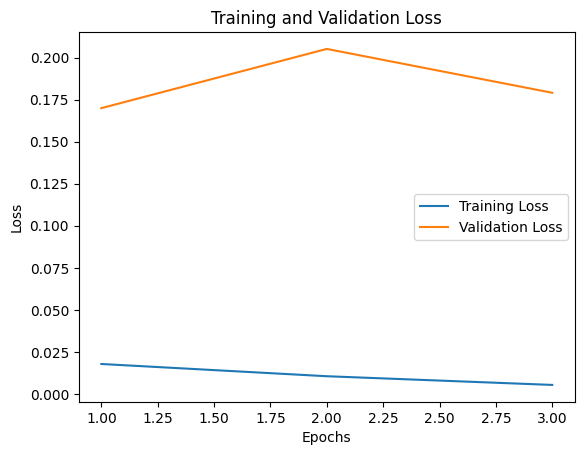

In [ ]:
import matplotlib.pyplot as plt

print(len(train_loss))
print(len(val_loss))

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()